In [1]:
import os
import sys
import re
import time
import yaml
import shutil
import argparse
import tarfile
import tempfile
import random
import subprocess
import copy

import torch

import boda
from boda.common import utils
from boda.common.utils import set_best, save_model, unpack_artifact, model_fn

import hypertune

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def save_proposals(proposals, args):
    save_dict = {
        'proposals': proposals,
        #'args'     : args,
        'timestamp'    : time.strftime("%Y%m%d_%H%M%S"),
        'random_tag'   : random.randint(100000,999999)
    }
    filename = f'proposals__{save_dict["timestamp"]}__{save_dict["random_tag"]}.pt'
    torch.save(save_dict, filename)
        
    if 'gs://' in args['Main args'].proposal_path:
        clound_target = os.path.join(args['Main args'].proposal_path,filename)
        subprocess.check_call(
            ['gsutil', 'cp', filename, clound_target]
        )
    else:
        os.makedirs(args['Main args'].proposal_path, exist_ok=True)
        shutil.copy(filename, args['Main args'].proposal_path)
    
    final_loc = os.path.join(args['Main args'].proposal_path,filename)
    print(f'Proposals deposited at:\n\t{final_loc}', file=sys.stderr)


In [3]:
def main(args):
    
    args_copy = copy.copy(args)
    
    params_module     = getattr(boda.generator.parameters, args['Main args'].params_module)
    energy_module    = getattr(boda.generator.energy    , args['Main args'].energy_module)
    generator_module = getattr(boda.generator           , args['Main args'].generator_module)
    
    params_args     = vars(params_module.process_args(args))
    energy_args    = vars(energy_module.process_args(args))
    generator_args = generator_module.process_args(args)
    generator_constructor_args, generator_runtime_args = [ vars(arg_subset) for arg_subset in generator_args ]
    
    params    = params_module(**params_args)
    energy    = energy_module(**energy_args)
    
    if args['Main args'].penalty_module is not None:
        penalty_module = getattr(boda.generator.energy, args['Main args'].penalty_module)
        energy.__class__ = type(
            'energy_module',
            (energy_module, penalty_module),
            vars(penalty_module.process_args(args))
        )
    else:
        penalty_module = None
    current_penalty = None

    generator_constructor_args['params']    = params
    generator_constructor_args['energy_fn'] = energy
    generator = generator_module(**generator_constructor_args)
    
    params.cuda()
    energy.cuda()
    
    proposal_sets = []
    for get_n in args['Main args'].n_proposals:
        generator_runtime_args['n_proposals'] = get_n
        proposal = generator.generate(**generator_runtime_args)
        proposal['penalty'] = current_penalty
        proposal_sets.append(proposal)
        
        sns.histplot(proposal['energies'].numpy())
        plt.show()
        
        if args['Main args'].penalty_module is not None:
            current_penalty = energy.update_penalty(proposal)
            
        if args['Main args'].reset_params:
            generator.params = params_module(**params_args)
            
    save_proposals(proposal_sets, args_copy)
    return params, energy, generator


In [4]:
if False:
    parser = argparse.ArgumentParser(description="BODA generator", add_help=False)
    group = parser.add_argument_group('Main args')
    
    group.add_argument('--params_module', type=str, required=True, help='')
    group.add_argument('--energy_module', type=str, required=True, help='')    
    group.add_argument('--generator_module', type=str, required=True, help='')
    group.add_argument('--penalty_module', type=str, help='')
    group.add_argument('--monitor', type=str, help='')
    group.add_argument('--n_proposals', type=list, help='')
    group.add_argument('--reset_params', type=utils.str2bool, default=True)
    group.add_argument('--proposal_path', type=str)
    
    group.add_argument('--tolerate_unknown_args', type=utils.str2bool, default=False, help='Skips unknown command line args without exceptions. Useful for HPO, but high risk of silent errors.')
    
    known_args, leftover_args = parser.parse_known_args()
    
    Params    = getattr(boda.generator, known_args.params_module)
    Energy    = getattr(boda.generator.energy, known_args.energy_module)
    Generator = getattr(boda.generator, known_args.generator_module)
    
    parser = Params.add_params_specific_args(parser)
    parser = Energy.add_energy_specific_args(parser)
    parser = Generator.add_generator_constructor_specific_args(parser)
    parser = Generator.add_generator_runtime_specific_args(parser)
    
    if known_args.penalty_module is not None:
        Penalty = getattr(boda.generator.energy, known_args.penalty_module)
        parser = Penalty.add_penalty_specific_args(parser)
        
    parser.add_argument('--help', '-h', action='help')
    
    if known_args.tolerate_unknown_args:
        args, leftover_args = parser.parse_known_args()
        print("Skipping unexpected args. Check leftovers for typos:", file=sys.stderr)
        print(leftover_args, file=sys.stderr)
    else:
        args = parser.parse_args()
        
    args = boda.common.utils.organize_args(parser, args)
    
    main(args)

In [5]:
cmd_str = '--params_module StraightThroughParameters ' +\
            '--batch_size 500 --n_channels 4 --length 200 ' +\
          '--energy_module OverMaxEnergy ' +\
            '--model_artifact gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz ' +\
            '--bias_cell 0 --bending_factor 0 ' +\
          '--generator_module FastSeqProp ' +\
            '--energy_threshold -2.0 --max_attempts 20 --n_steps 100 ' +\
          '--penalty_module StremePenalty ' +\
            '--score_pct 0.3 ' +\
          '--proposal_path ./test_seqs/ --n_proposals 500 500 500 500 500 '

'python /home/ubuntu/boda2/src/generate.py ' + cmd_str

'python /home/ubuntu/boda2/src/generate.py --params_module StraightThroughParameters --batch_size 500 --n_channels 4 --length 200 --energy_module OverMaxEnergy --model_artifact gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz --bias_cell 0 --bending_factor 0 --generator_module FastSeqProp --energy_threshold -2.0 --max_attempts 20 --n_steps 100 --penalty_module StremePenalty --score_pct 0.3 --proposal_path ./test_seqs/ --n_proposals 500 500 500 500 500 '

In [6]:
cmd_str = '--params_module BasicParameters ' +\
            '--batch_size 500 --n_channels 4 --length 200 ' +\
          '--energy_module OverMaxEnergy ' +\
            '--model_artifact gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz ' +\
            '--bias_cell 0 --bending_factor 0 ' +\
          '--generator_module SimulatedAnnealing ' +\
            '--n_positions 1 --a 1 --b 1 --gamma 1 ' +\
            '--energy_threshold 1000.0 --max_attempts 20 --n_steps 100 ' +\
          '--penalty_module StremePenalty ' +\
            '--score_pct 0.3 ' +\
          '--proposal_path ./test_seqs/ --n_proposals 500 500 500 500 500 '

'python /home/ubuntu/boda2/src/generate.py ' + cmd_str

'python /home/ubuntu/boda2/src/generate.py --params_module BasicParameters --batch_size 500 --n_channels 4 --length 200 --energy_module OverMaxEnergy --model_artifact gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz --bias_cell 0 --bending_factor 0 --generator_module SimulatedAnnealing --n_positions 1 --a 1 --b 1 --gamma 1 --energy_threshold 1000.0 --max_attempts 20 --n_steps 100 --penalty_module StremePenalty --score_pct 0.3 --proposal_path ./test_seqs/ --n_proposals 500 500 500 500 500 '

In [7]:
parser = argparse.ArgumentParser(description="BODA generator", add_help=False)
group = parser.add_argument_group('Main args')

group.add_argument('--params_module', type=str, required=True, help='')
group.add_argument('--energy_module', type=str, required=True, help='')    
group.add_argument('--generator_module', type=str, required=True, help='')
group.add_argument('--penalty_module', type=str, help='')
group.add_argument('--monitor', type=str, help='')
group.add_argument('--n_proposals', nargs='+', type=int, help='')
group.add_argument('--energy_threshold', type=float, default=float("Inf"))
group.add_argument('--max_attempts', type=int, default=10000)
group.add_argument('--reset_params', type=utils.str2bool, default=True)
group.add_argument('--proposal_path', type=str)

group.add_argument('--tolerate_unknown_args', type=utils.str2bool, default=False, help='Skips unknown command line args without exceptions. Useful for HPO, but high risk of silent errors.')

_StoreAction(option_strings=['--tolerate_unknown_args'], dest='tolerate_unknown_args', nargs=None, const=None, default=False, type=<function str2bool at 0x7f8bb8fb04d0>, choices=None, help='Skips unknown command line args without exceptions. Useful for HPO, but high risk of silent errors.', metavar=None)

In [8]:
known_args, leftover_args = parser.parse_known_args(
    cmd_str.rstrip().split()
)

known_args

Namespace(energy_module='OverMaxEnergy', energy_threshold=1000.0, generator_module='SimulatedAnnealing', max_attempts=20, monitor=None, n_proposals=[500, 500, 500, 500, 500], params_module='BasicParameters', penalty_module='StremePenalty', proposal_path='./test_seqs/', reset_params=True, tolerate_unknown_args=False)

In [9]:
Params    = getattr(boda.generator, known_args.params_module)
Energy    = getattr(boda.generator.energy, known_args.energy_module)
Generator = getattr(boda.generator, known_args.generator_module)


In [10]:
parser = Params.add_params_specific_args(parser)
parser = Energy.add_energy_specific_args(parser)
parser = Generator.add_generator_specific_args(parser)


In [11]:
if known_args.penalty_module is not None:
    Penalty = getattr(boda.generator.energy, known_args.penalty_module)
    parser = Penalty.add_penalty_specific_args(parser)


In [12]:
parser.add_argument('--help', '-h', action='help')

if known_args.tolerate_unknown_args:
    args, leftover_args = parser.parse_known_args( 
        cmd_str.rstrip().split()
    )
    print("Skipping unexpected args. Check leftovers for typos:", file=sys.stderr)
    print(leftover_args, file=sys.stderr)
else:
    args = parser.parse_args(
        cmd_str.rstrip().split()
    )

args = boda.common.utils.organize_args(parser, args)


Namespace(a=1.0, b=1.0, batch_dim=0, batch_size=500, bending_factor=0.0, bias_alpha=1.0, bias_cell=0, cat_axis=-1, energy_module='OverMaxEnergy', energy_threshold=1000.0, gamma=1.0, generator_module='SimulatedAnnealing', init_seqs=None, keep_burnin=False, left_flank='GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCATTACATCTGTGTGTTGGTTTTTTGTGTGAATCGATAGTACTAACATACGCTCTCCATCAAAACAAAACGAAACAAAACAAACTAGCAAAATAGGCTGTCCCCAGTGCAAGTGCAGGTGCCAGAACATTTCTCTGGCCTAACTGGCCGCTTGACG', length=200, max_attempts=20, model_artifact='gs://syrgoth/aip_ui_test/model_artifacts__20211110_194934__672830.tar.gz', monitor=None, n_burnin=0, n_channels=4, n_positions=1, n_proposals=[500, 500, 500, 500, 500], n_steps=100, params_module='BasicParameters', penalty_module='StremePenalty', proposal_path='./test_seqs/', reset_params=True, right_flank='CACTGCGGCTCCTGCGATCTAACTGGCCGGTACCTGAGCTCGCTAGCCTCGAGGATATCAAGATCTGGCCTCGGCGGCCAAGCTTAGACACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCCGGTACTGTTGGTAAAGCCACCATGGTGAGCAAGGGCGAGGA

In [13]:
args

{'positional arguments': Namespace(),
 'optional arguments': Namespace(help=None),
 'Main args': Namespace(energy_module='OverMaxEnergy', energy_threshold=1000.0, generator_module='SimulatedAnnealing', max_attempts=20, monitor=None, n_proposals=[500, 500, 500, 500, 500], params_module='BasicParameters', penalty_module='StremePenalty', proposal_path='./test_seqs/', reset_params=True, tolerate_unknown_args=False),
 'Params Module args': Namespace(batch_dim=0, batch_size=500, cat_axis=-1, init_seqs=None, left_flank='GTACGGGAGGTATTGGACAGGCCGCAATAAAATATCTTTATTTTCATTACATCTGTGTGTTGGTTTTTTGTGTGAATCGATAGTACTAACATACGCTCTCCATCAAAACAAAACGAAACAAAACAAACTAGCAAAATAGGCTGTCCCCAGTGCAAGTGCAGGTGCCAGAACATTTCTCTGGCCTAACTGGCCGCTTGACG', length=200, n_channels=4, right_flank='CACTGCGGCTCCTGCGATCTAACTGGCCGGTACCTGAGCTCGCTAGCCTCGAGGATATCAAGATCTGGCCTCGGCGGCCAAGCTTAGACACTAGAGGGTATATAATGGAAGCTCGACTTCCAGCTTGGCAATCCGGTACTGTTGGTAAAGCCACCATGGTGAGCAAGGGCGAGGAGCTGTTCACCGGGGTGGTGCCCATC'),
 'Energy Module args': Namespace(be

Loaded model from 20211110_194934 in eval mode


collect samples
  0%|          | 0/100 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 100/100 [00:03<00:00, 27.52it/s]


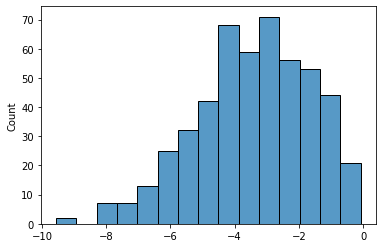

collect samples
100%|██████████| 100/100 [00:05<00:00, 17.67it/s]


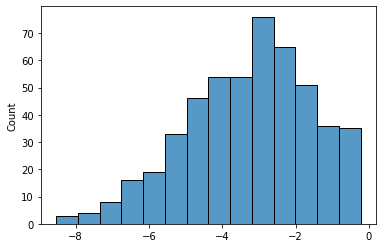

collect samples
100%|██████████| 100/100 [00:05<00:00, 17.67it/s]


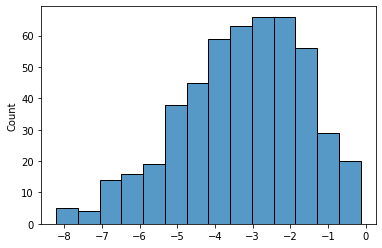

collect samples
100%|██████████| 100/100 [00:05<00:00, 17.71it/s]


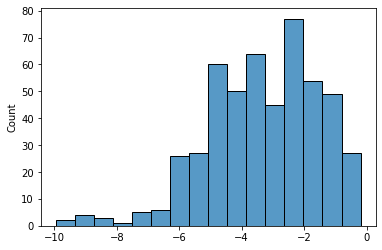

collect samples
100%|██████████| 100/100 [00:05<00:00, 17.69it/s]


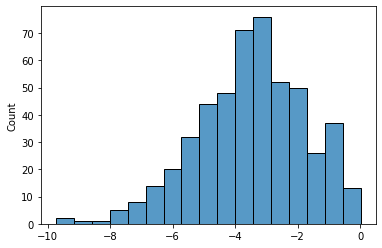

Proposals deposited at:
	./test_seqs/proposals__20211122_202643__634347.pt


In [14]:
params, energy, generator = main(args)